# Density based retrieval relevance

An important aspect of using embeddings-based retreival systems like Chroma is knowing whether there are relevant results to a given query in the existing dataset. As application developers, we would like to know when the system doesn't have enough information to complete a given query or task - we want to know what we don't know. 

This is particularly important in the case of retrieval-augmented generation, since it's [often been observed](https://arxiv.org/abs/2302.00093) that supplying irrelevant context serves to confuse the generative model, leading to the degredation of application performance in ways that are difficult to detect. 

Unlike a relational database which will not return results if none match the query, a vector search based retrieval system will return the $k$ nearest neighbors to any given query, whether they are relevant or not. 

One possible approach one might take is to tune a distance threshold, and reject any results which fall further away from the query. This might be suitable for certain kind of fixed datasets, but in practice such thresholds tend to be very brittle, and often serve to exclude many relevant results while not always excluding irrelevant ones. Additionally, the threshold will need to be continously adapted as the data changes. Additionally, such distance thresholds are not comparable across embedding models for a given dataset, nor across datasets for a given embedding model. 

We would prefer to find a data driven approach which can:
- produce a uniform and comparable measure of relevance for any dataset 
- automatically adapt as the underlying data changes 
- is relatively inexpensive to compute

This notebook demonstrates one possible such approach, which relies on the distribution of distances (pseudo 'density') between points in a given dataset. For a given result, we use compute the percentile the result's distance to the query falls into with respect to the overall distribution of distances in the dataset. This approach produces a uniform measure of relevance for any dataset, and is relatively cheap to compute, and can be computed online as data mutates. 

This approach is still very preliminary, and we welcome contributions and alternative approaches - some ideas are listed at the end of this notebook.

## Preliminaries

In [48]:
# Install required packages

import sys
!{sys.executable} -m pip install chromadb numpy umap-learn matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Dataset

As a demonstration we use the [SciQ dataset](https://arxiv.org/abs/1707.06209), available from [HuggingFace](https://huggingface.co/datasets/sciq). 

Dataset description, from HuggingFace:

> The SciQ dataset contains 13,679 crowdsourced science exam questions about Physics, Chemistry and Biology, among others. The questions are in multiple-choice format with 4 answer options each. For the majority of the questions, an additional paragraph with supporting evidence for the correct answer is provided.

In [52]:
# Get the SciQ dataset from HuggingFace
from datasets import load_dataset

dataset = load_dataset("sciq", split="train")

# Filter the dataset to only include questions with a support
dataset = dataset.filter(lambda x: x['support'] != '')

print("Number of questions with support: ", len(dataset))

Found cached dataset sciq (/Users/antontroynikov/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493)
Loading cached processed dataset at /Users/antontroynikov/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493/cache-9181e6e3516ba4ed.arrow


Number of questions with support:  10481


### Data loading 

We load the dataset into a local persistent instance of Chroma, into a collection called `sciq`. We use Chroma's [default embedding function](https://docs.trychroma.com/embeddings#default-all-minilm-l6-v2), all-MiniLM-L6-v2 from [sentence tranformers](https://www.sbert.net/).

In [53]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.Client(Settings(
    chroma_db_impl="duckdb+parquet",
    persist_directory="./"
))

collection = chroma_client.get_or_create_collection(name="sciq")

In [4]:
# Load the data and persist 
collection.add(ids=[str(i) for i in range(len(dataset['support']))], documents=dataset['support'], metadatas=[{'type': 'support'} for _ in range(len(dataset['support']))])
chroma_client.persist()

True

## Computing a distribution over distances (pseudo density function)

We would like to understand the distribution of distances between points in the dataset. 

To do so, we:

1. Get the computed embeddings of each supporting sentence in the dataset. 
2. Use Chroma to efficiently find the distance to each sentence's nearest neighbor.
3. Compute a cumulative density function over distances. 

Subsequently we can use this cumulative density function to estimate query relevance, by finding the percentile of a given result's distance from the query according to the CDF. 
A lower percentile means that 

In [13]:
# Get the embeddings for the support documents from the collection
support_embeddings = collection.get(include=['embeddings'])['embeddings']

### Visualization

It can be helpful to visualize the embeddings to get a sense of how they might be distributed and see if there is any obvious structure. We use the [UMAP library](https://umap-learn.readthedocs.io/en/latest/plotting.html) to fit a 2D mainfold to the high-dimensional embedding data, and visualize it. 

In [54]:
import umap
import umap.plot

mapper = umap.UMAP().fit(support_embeddings)
umap.plot.points(mapper)

AttributeError: module 'umap' has no attribute 'UMAP'

We query the collection using the embeddings for each element, returning the distances. Note that we query for two results, since the first (nearest) result will be the element we're querying with. 

In [55]:
dists = collection.query(query_embeddings=support_embeddings, n_results=2, include=['distances'])

In [56]:
# Flatten the distances list, excluding the first element (which is an element's distance to itself)
flat_dists = [item for sublist in dists['distances'] for item in sublist[1:]]

There are some details to note here. Because we query with each element, when two elements are each other's nearest neighbors, the same distance will appear in the result twice. This isn't necessarily a problem if we're computing a cumulative density, as the doubling is taken into account when we normalize to get a cumulative distribution function. 

However, it is not always the case that the nearest neighbor of some element $a$, will have $a$ as its own nearest neighbor. This could be taken into account by appropriately filtering pairwise matches using the element IDs, but for simplicity we ignore it here. 

### Computing the density function over distances 

Using the returned distances, we compute the density function using `numpy`. 

In [57]:
# Compute a density function over the distances
import numpy as np
hist, bin_edges = np.histogram(flat_dists, bins=100, density=True)
cumulative_density = np.cumsum(hist) / np.sum(hist)

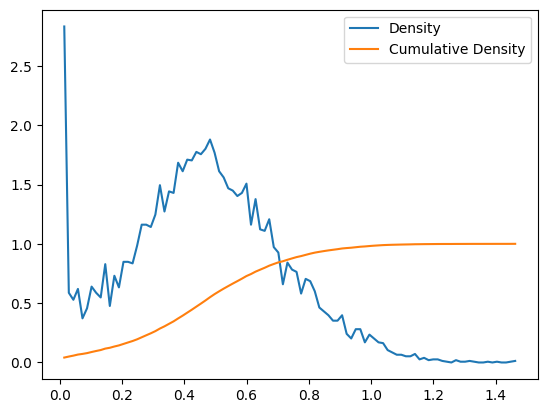

In [59]:
# Plot the density function
import matplotlib.pyplot as plt
plt.plot(bin_edges[1:], hist, label="Density")
plt.plot(bin_edges[1:], cumulative_density, label="Cumulative Density")
plt.legend(loc="upper right")
plt.show()


### Computing relevance using the density function

We use the percentile a given query falls into with respect to the overall distribution of distances between elements of the dataset, to estimate its relevance. Intuitively, results which are less relevant to the query, should be in higher percentiles than those which are more relevant. 

By using the distribution of distances in this way, we eliminate the need to tune an explicit distance threshold, and can instead reason in terms of likelihoods. We could either apply a threshold to the percentile-based relevance directly, or else feed this information into a re-ranking model, or take a sampling approach. 

In [23]:
def compute_percentile(dist):
    index = np.searchsorted(bin_edges[1:], dist, side='right')
    return cumulative_density[index - 1]

## Evaluation

We evaluate the percentile based relevance score using the SciQ dataset. 

1. We query the collection of supporting sentences using the questions from the dataset, returning the 10 nearest results, along with their distances.
2. We check the results for whether the supporting sentence is present or absent. If it's present in the results, we record the percentile that the support falls into, otherwise we record the percentile of the nearest result. 

In [20]:
question_results = collection.query(query_texts=dataset['question'], n_results=10, include=['documents', 'distances'])

In [41]:
support_percentiles = []
missing_support_percentiles = []
for i, q in enumerate(dataset['question']):
    support = dataset['support'][i]
    if support in question_results['documents'][i]:
        support_index = question_results['documents'][i].index(support)
        percentile = compute_percentile(question_results['distances'][i][support_index])
        support_percentiles.append(percentile)
    else:
        missing_support_percentiles.append(compute_percentile(question_results['distances'][i][0]))

Question: What phenomenon makes global winds blow northeast to southwest or the reverse in the northern hemisphere and northwest to southeast or the reverse in the southern hemisphere?, Support: Without Coriolis Effect the global winds would blow north to south or south to north. But Coriolis makes them blow northeast to southwest or the reverse in the Northern Hemisphere. The winds blow northwest to southeast or the reverse in the southern hemisphere., Percentile: 0.49632668638488703
Question: What is the least dangerous radioactive decay?, Support: All radioactive decay is dangerous to living things, but alpha decay is the least dangerous., Percentile: 0.4198072702986356
Question: When a meteoroid reaches earth, what is the remaining object called?, Support: Meteoroids are smaller than asteroids, ranging from the size of boulders to the size of sand grains. When meteoroids enter Earth’s atmosphere, they vaporize, creating a trail of glowing gas called a meteor. If any of the meteoroi

KeyboardInterrupt: 

### Visualization

We plot histograms of the percentiles for the cases where the support was found, and the case where it wasn't. A lower percentile is more relevant. 

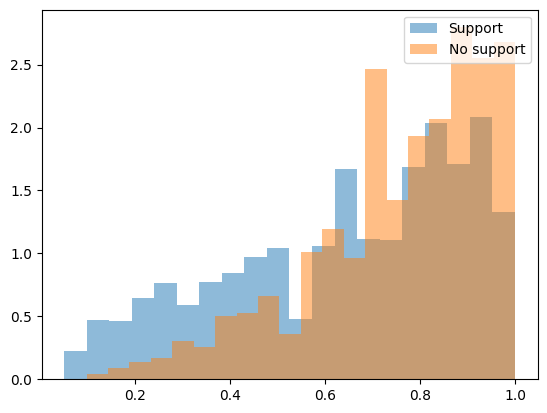

In [47]:
# Plot normalized histograms of the percentiles
plt.hist(support_percentiles, bins=20, density=True, alpha=0.5, label='Support')
plt.hist(missing_support_percentiles, bins=20, density=True, alpha=0.5, label='No support')
plt.legend(loc='upper right')
plt.show()

### Preliminary results

While we don't observe a clear separation of the two classes, we do note that in general, supports tend to be in lower percentiles, and hence more relevant, than results which aren't the support. 

One possible confounding factor is that in some cases, the result does contain the answer to the query question, but is not itself the support for that question. 

In [65]:
for i, q in enumerate(dataset['question'][:20]):
    support = dataset['support'][i]
    top_result = question_results['documents'][i][0]

    if support != top_result:
        print(f"Question: {q} \nSupport: {support} \nTop result: {top_result}\n")

Question: What type of organism is commonly used in preparation of foods such as cheese and yogurt? 
Support: Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine. 
Top result: Bacteria can be used to make cheese from milk. The bacteria turn the milk sugars into lactic acid. The acid is what causes the milk to curdle to form cheese. Bacteria are also involved in producing other foods. Yogurt is made by using bacteria to ferment milk ( Figure below ). Fermenting cabbage with bacteria produces sauerkraut.

Question: Changes from a less-ordered state to a more-ordered state (such as a liquid to a solid) are always what? 
Support: Summary Changes of state a

### Conclusion

This notebook presents one possible approach to computing a relevance score for embeddings-based retreival, based on the distribution of distances between datapoints. We have done some initial evaluation, but there is a lot left to do. 

Some things to try include:
- 